# Preprocessing and clustering 3k PBMCs using federate PCA

This documentation shows to which extend centralized PCA can be replaced with federated PCA. It is not meant as a fullly federated study, but mererly focuses on PCA. Nonetheless it would be possible to reproduce the summary statistic based preprocessing. Some preprocessing steps might not be immediatly federate-able such as regressing out the mitochondrial content. We are working on making more federated data anlysis methods available in the future. 

This is a modified version of the scanpy vignette. Verbatim content is marked in *italic*.

*In May 2017, this started out as a demonstration that Scanpy would allow to reproduce most of Seurat's [guided clustering tutorial](http://satijalab.org/seurat/pbmc3k_tutorial.html) ([Satija et al., 2015](https://doi.org/10.1038/nbt.3192)).*

*We gratefully acknowledge Seurat's authors for the tutorial! In the meanwhile, we have added and removed a few pieces.*
    
*The data consist of 3k PBMCs from a Healthy Donor and are freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). On a unix system, you can uncomment and run the following to download and unpack the data. The last line creates a directory for writing processed data.*

In [62]:
# !mkdir -p /home/anne/Documents/featurecloud/pca/scanpy/data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O /home/anne/Documents/featurecloud/pca/scanpy/data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd /home/anne/Documents/featurecloud/pca/scanpy/data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
# !mkdir /home/anne/Documents/featurecloud/pca/scanpy/write

In [63]:
basedir = '/home/anne/Documents/manuscripts/horizontal-pca'
pcapath = '/home/anne/Documents/featurecloud/pca/federated_dp_pca'
datapath = '/home/anne/Documents/featurecloud/pca/scanpy/data/filtered_gene_bc_matrices/hg19/'
outdir = '/home/anne/Documents/featurecloud/pca/horizontal-pca/results/single-cell'

## Preprocessing

The preprocessing has been done according to the scanpy vignette.

In [64]:
# system packages
import numpy as np
import pandas as pd
import scanpy as sc
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import scipy.linalg as la
import scipy.sparse.linalg as lsa
import os.path as op
import os

# simulation code
sys.path.append(pcapath)
from python.PCA.horizontal.horizontal_pca_benchmark import wrapper_k_variation
import python.PCA.shared_functions as sh
import python.PCA.horizontal.horizontal_pca_power_iteration as h
import python.PCA.horizontal.balcan as b
import python.PCA.horizontal.bai as bai
import python.PCA.horizontal.proxy_covariance as proxy
import python.PCA.vertical.simulate_federated_vertically_partionned_pca as vertical
import python.PCA.horizontal.leave1out as l1o

import python.PCA.comparison as co
sc.settings.set_figure_params(dpi=80, facecolor='white')
sc.settings.figdir=op.join(basedir, 'figures/single-cell/')

## Run a consolidated version of the preprocessing in the vignette.

In [65]:
adata = sc.read_10x_mtx(
    datapath,  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True) # write a cache file for faster subsequent reading
adata.var_names_make_unique() 
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

/home/anne/miniconda3/envs/federated_dp_pca/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [66]:
# this is the version for dense matrices
u,s,v = sp.linalg.svd(adata[:,adata.var['highly_variable']].X)


## Simulation of Federated Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In order to understand the potential problems with federated principal component analysis for dimensionality reduction in federated setting, federated PCA is simulated using different approaches: Federated Power iteration, an exact algorithm and approximate PCA from this publication:

*Maria-Florina Balcan, Vandana Kanchanapally, Yingyu Liang, and David Woodruff. Improved distributed principalcomponent analysis. In Proceedings of the 27th International Conference on Neural Information Processing Systems -Volume 2, NIPS’14, page 3113–3121, Cambridge, MA, USA,2014. MIT Press.*

In [67]:
np.random.seed(40)

Split the data into different chunks. Here, the data is horizontally partionned. This means, the cells are partionned over several virtual sites, but measurements for all genes are available.

In [68]:
data_list, r = sh.partition_data_horizontally(adata.X, splits=5, equal=True, randomize=False)

In [69]:
os.makedirs(outdir, exist_ok = True)

## Compare scanpy's PCA with simulated federated PCA
### Standard PCA used in scanpy (under the hood scipy> LAPACK)

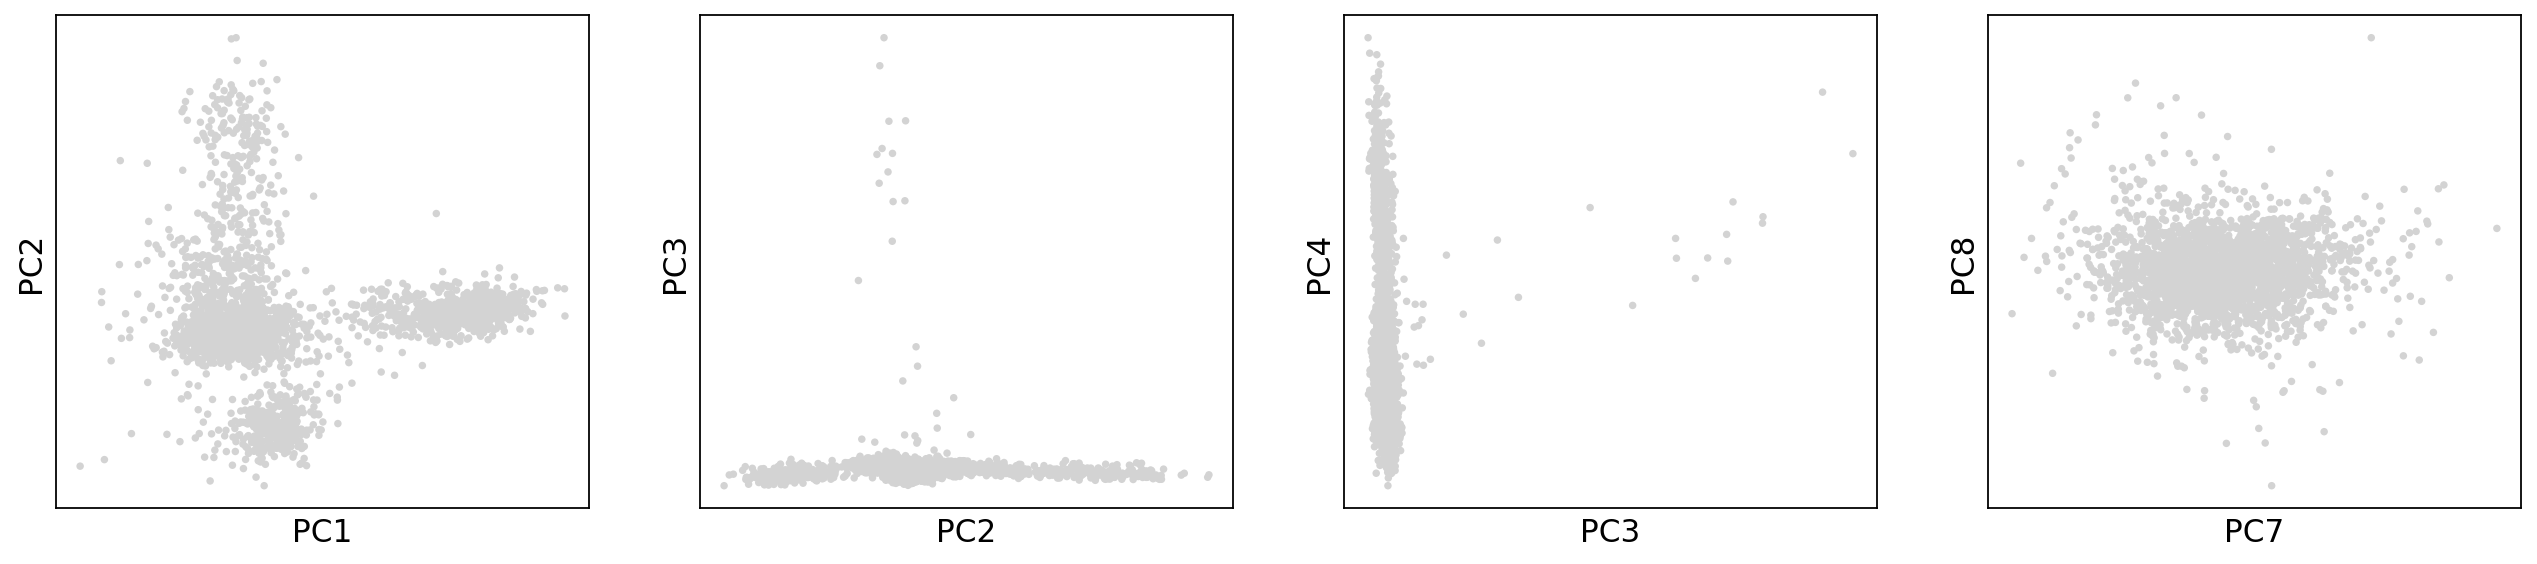

In [70]:
# compute scanpy's standard PCA
sc.tl.pca(adata)
sc.pl.pca(adata,components =['1,2', '2,3','3,4', '7,8'], save='powerit')

### Simulated federated Power iteration.
This is just to show that federated Power Iteration converges to the same solution as centralized PCA, up to the sign of the eigenvectors.

converged: 500


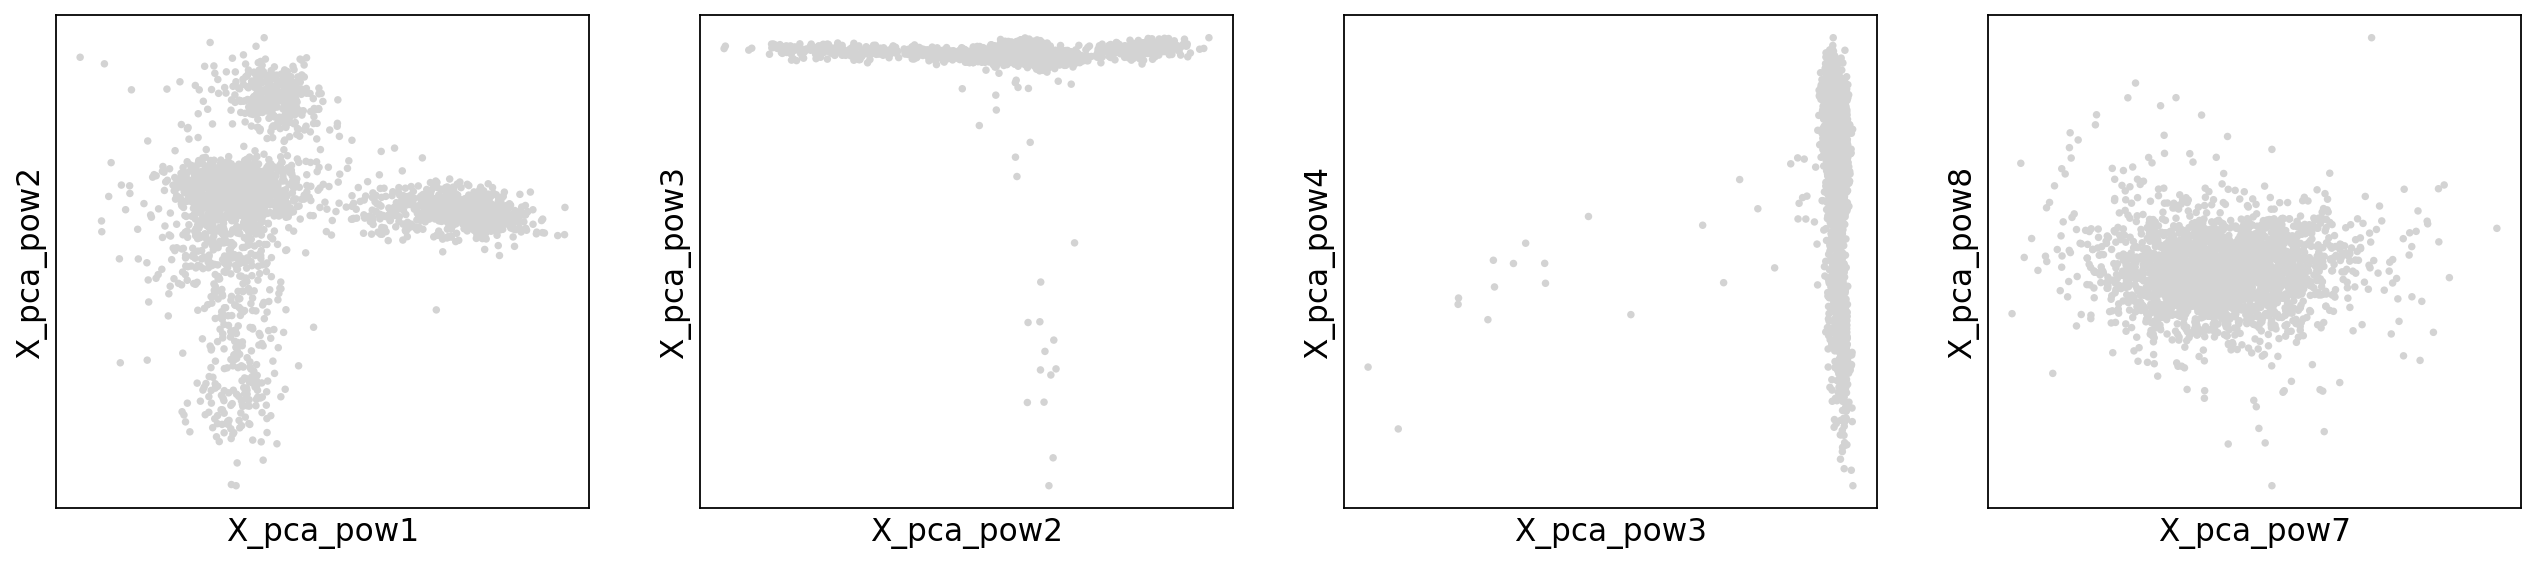

In [71]:
# simulated fedeated power iteration 
k= 50
x, e, count = h.simulate_distributed_horizontal(data_list, k, maxit=500)
proj = np.dot(adata.X, x)
adata.obsm['X_pca_pow'] = proj
adata.varm['PCs_pow'] = x
sc.pl.embedding(adata, basis='X_pca_pow', components =['1,2', '2,3','3,4', '7,8'])

### Simulate federated approximate PCA
#### Randomize and split the data

In [72]:
# k =10
np.random.seed(40)
X = adata.X
X = X[np.random.choice(X.shape[0], X.shape[0], replace=False)]
data_list, r = sh.partition_data_horizontally(X, splits=5, equal=True, randomize=False)
k = 50

#### Simulate the PCA and project the data onto the eigenvectors

In [73]:
xx, ee = b.simulate_federated_horizontal_pca(data_list, k)
proj = np.dot(adata.X, xx)
adata.obsm['PC'] = proj
adata.varm['PCs_approx'] = xx

(100, 1838)
(100, 1838)
(100, 1838)
(100, 1838)
(100, 1838)
Intermediate dimensions100
(500, 1838)


#### Plot the embedding and Compute some statistics.

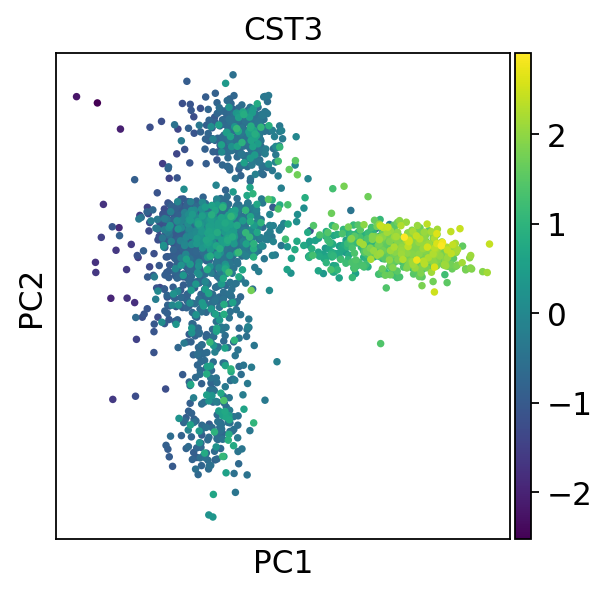

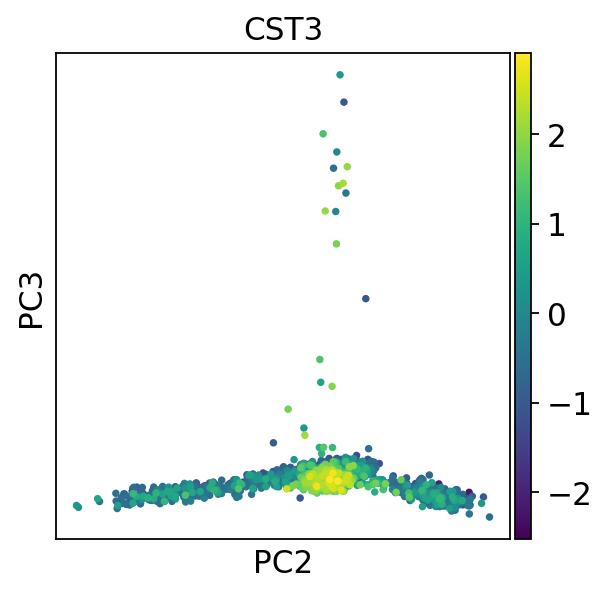

In [74]:
sc.pl.embedding(adata, color='CST3', basis = 'PC', components =['1,2'], save='CST3_12_k50_s40')
sc.pl.embedding(adata, color='CST3', basis = 'PC', components =['2,3'], save='CST3_23_k50_s40')

angles = co.compute_angles(adata.varm['PCs_approx'], adata.varm['PCs'])[0:10]
angles = [np.round(a, 2) for a in angles]
sre = co.subspace_reconstruction_error(X, xx)
sre_orig = co.subspace_reconstruction_error(X, adata.varm['PCs'][:,0:50])

#### Plot the embedding of the original PCA

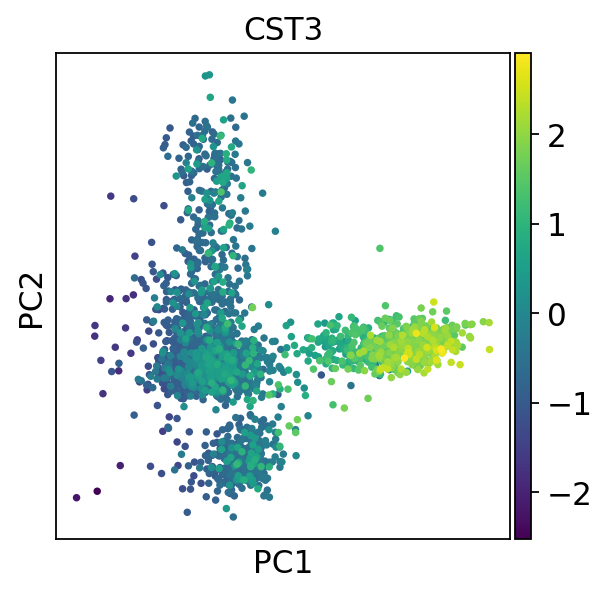

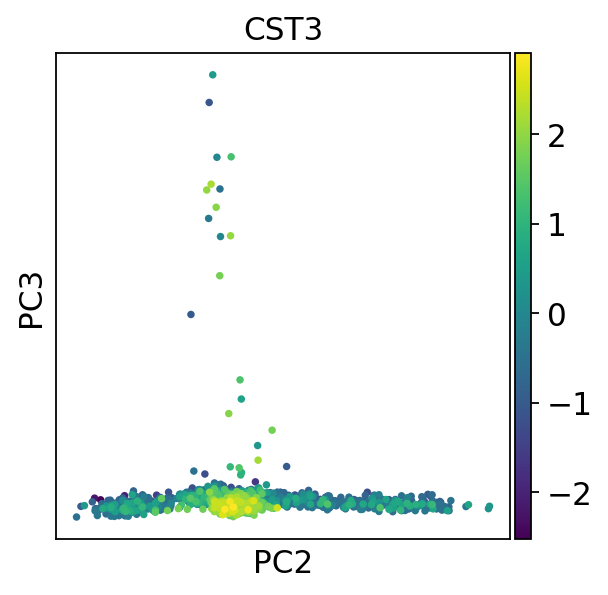

In [75]:
sc.pl.pca(adata, color='CST3', components =['1,2'], save='CST3_12_centralised')
sc.pl.pca(adata, color='CST3', components =['2,3'], save='CST3_23_centralised')

In [76]:
### results: save

In [77]:
angles = co.compute_angles(adata.varm['PCs_approx'], adata.varm['PCs'])[0:10]
angles = [np.round(a, 2) for a in angles]
pd.DataFrame(angles).to_csv('/home/anne/Documents/featurecloud/pca/horizontal-pca/results/single-cell/angles_cent_approx_s40.tsv', sep='\t')

### Computing the neighborhood graph: Canonical PCA

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix using the canonical PCA.

In [78]:
sc.pp.neighbors(adata, use_rep='X_pca')

In [79]:
sc.tl.umap(adata)

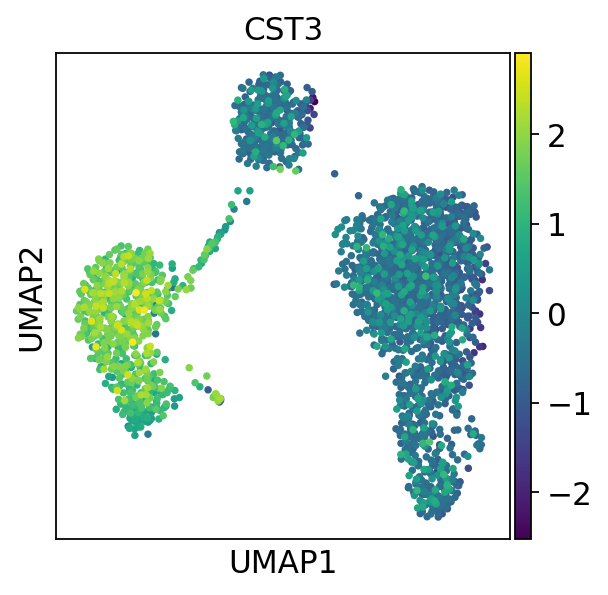

In [80]:
sc.pl.umap(adata, color=['CST3'], save='CST3_centralised')

### Neighborhood graph: Federated PCA

In [81]:
sc.pp.neighbors(adata, use_rep='PC', key_added='approx')

In [82]:
sc.tl.umap(adata, neighbors_key='approx')

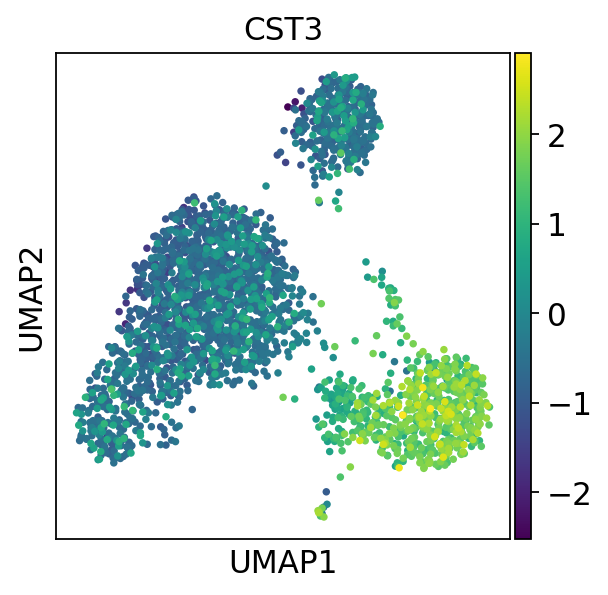

In [83]:
sc.pl.umap(adata, color=['CST3'], neighbors_key='approx',  save='CST3_approx_s40')

## Loadings: The coordinates of the eigenvectors
Compare the topmost and lowest coordinates and the genes associated with these coordinates. See if the same genes are identified using canonical PCA and federated approximate PCA.

In [84]:
def compare_loadings(x, x0):
    ttl = [] # top ten loading
    tll = [] # ten lowest loadings
    li = min(20, x.shape[1])
    t1 = 20
    

    for i in range(li):
        top10m = adata.var.index[np.argsort(-x[:,i])[0:t1]]
        low10m = adata.var.index[np.argsort(-x[:,i])[-(t1+1):-1]]
        top10 = adata.var.index[np.argsort(x[:,i])[0:t1]]
        low10 = adata.var.index[np.argsort(x[:,i])[-(t1+1):-1]]
        top10scanpy = adata.var.index[np.argsort(x0[:,i])[0:t1]]
        low10scanpy = adata.var.index[np.argsort(x0[:,i])[-(t1+1):-1]]
        ttl.append(max(len(top10.intersection(top10scanpy)), len(top10m.intersection(top10scanpy))))
        tll.append(max(len(low10.intersection(low10scanpy)), len(low10m.intersection(low10scanpy))))
    return ttl, tll

Surprise: The overlap is not great for higher rank eigenvectors

In [85]:
# orthonormalise eigenvectors before use!!!
adata.varm['PCs'],x = la.qr(adata.varm['PCs'], mode='economic')
adata.varm['PCs_approx'],x = la.qr(adata.varm['PCs_approx'], mode='economic')
#adata.varm['PCs'],x = la.qr(adata.varm['PCs'], mode='economic')

In [86]:
np.sign(-1)

-1

In [87]:
adata.varm['PCs_approx']

array([[-0.02621118, -0.00517227, -0.0135433 , ..., -0.00122279,
        -0.00062723,  0.00853888],
       [-0.00829355, -0.00895231,  0.00296918, ...,  0.02895058,
        -0.033095  ,  0.00077149],
       [-0.00337049, -0.00320879, -0.00129961, ...,  0.00518585,
         0.00211197,  0.00130197],
       ...,
       [ 0.00770349,  0.00213365,  0.00438765, ..., -0.0112004 ,
         0.03005057,  0.03582599],
       [-0.01574246, -0.04111867,  0.00707356, ..., -0.00648463,
         0.01003129, -0.06995281],
       [-0.01437024, -0.03931992, -0.00621605, ...,  0.03213338,
        -0.01389579, -0.00065659]])

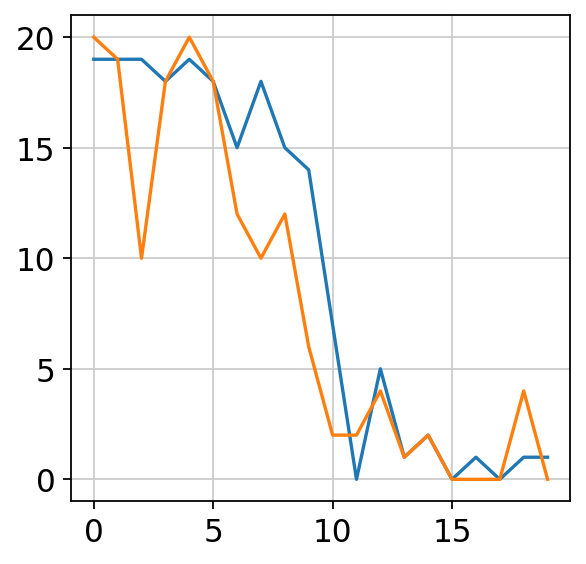

In [88]:
ttl, tll = compare_loadings(adata.varm['PCs'],adata.varm['PCs_approx'])
sns.lineplot(x =range(len(ttl)), y = ttl)
sns.lineplot(x =range(len(tll)), y = tll)

pd.DataFrame(ttl).to_csv('/home/anne/Documents/featurecloud/pca/horizontal-pca/results/single-cell/overlap_top_s40.tsv', sep='\t')
pd.DataFrame(tll).to_csv('/home/anne/Documents/featurecloud/pca/horizontal-pca/results/single-cell/overlap_bottom_s40.tsv', sep='\t')

## Recompute the approximate PCA using different random seeds
### Seed = 30

(100, 1838)
(100, 1838)
(100, 1838)
(100, 1838)
(100, 1838)
Intermediate dimensions100
(500, 1838)


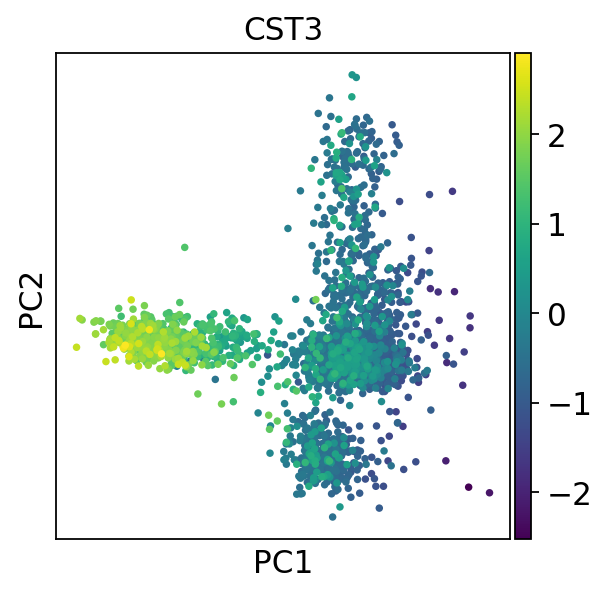

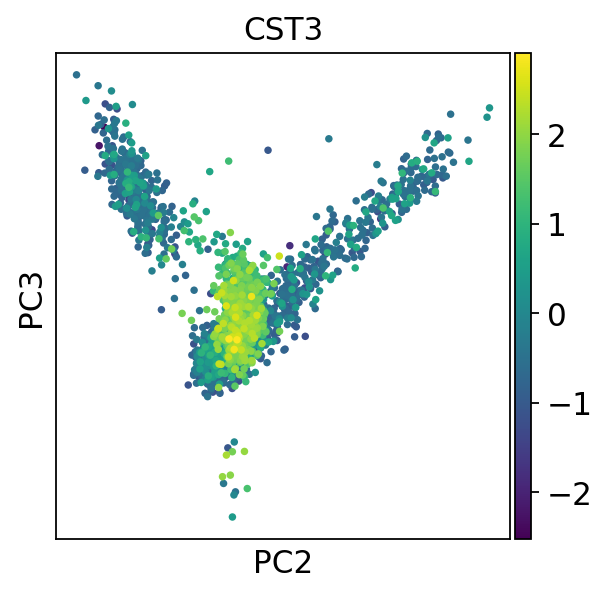

In [89]:
# simulate federated approximate PCA with lower k
np.random.seed(30)
X = adata.X
c = np.random.choice(X.shape[0], X.shape[0], replace=False)
X = X[c]
data_list, r = sh.partition_data_horizontally(X, splits=5, equal=True, randomize=False)
dl= [d.shape[0] for d in data_list]
k = 50
xx, ee = b.simulate_federated_horizontal_pca(data_list, k)
proj = np.dot(adata.X, xx)
adata.obsm['PC'] = proj
adata.varm['PCs_approx'] = xx
sc.pl.embedding(adata, color='CST3', basis = 'PC', components =['1,2'], save='CST3_12_k50_s30')
sc.pl.embedding(adata, color='CST3', basis = 'PC', components =['2,3'], save='CST3_23_k50_s30')

The result looks much different for PC2 vs. PC3. But the UMAP looks ok.

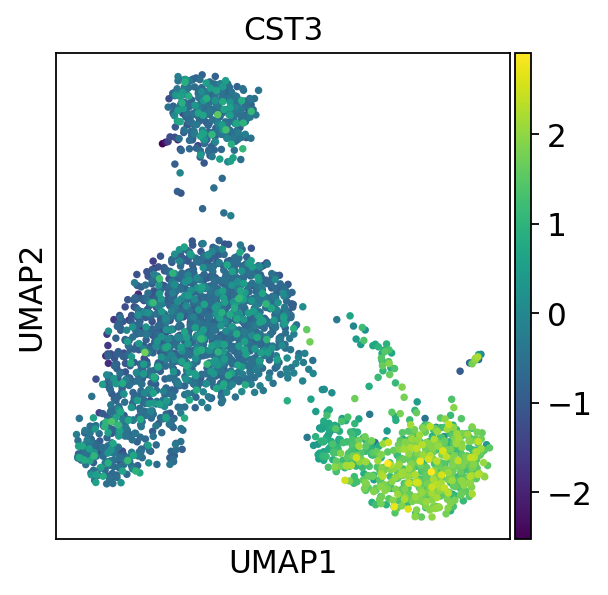

In [90]:
sc.pp.neighbors(adata, use_rep='PC', key_added='approx')
sc.tl.umap(adata, neighbors_key='approx')
sc.pl.umap(adata, color=['CST3'], neighbors_key='approx',  save='CST3_approx_k50_s30')

Here we crudely identify some outliers. Depending on the orientation of the eigenvectors the sign might change. These outliers are distributed in a biased fashion in the simulated federated run. Depending on the seed. 

<AxesSubplot:ylabel='Count'>

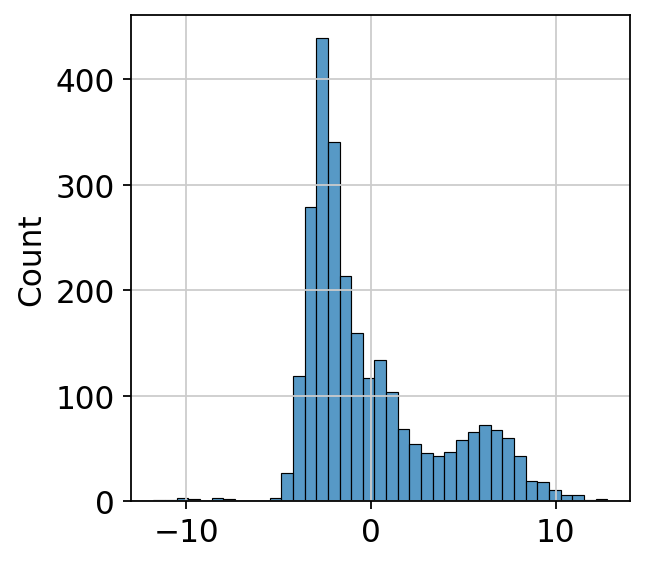

In [91]:
#
sns.histplot(proj[:,2])

In [92]:
ol = np.where(proj[:,2]<-6)[0]

#### Determine the indices in each partition and and the outlier indices per partition
Here we see that one site has no outlier, and one has only 1.

In [93]:
boundaries = []
current= 0
cho = []
for d in dl:
    cho.append(c[current:current+d])
    current = current+d
    boundaries.append(current)
section = [set(ol).intersection(cc) for cc in cho]

In [94]:
section
nol = [len(d) for d in section]

In [95]:
nol

[4, 2, 5, 0, 1]

Outliers per site: [4, 2, 5, 0, 1]

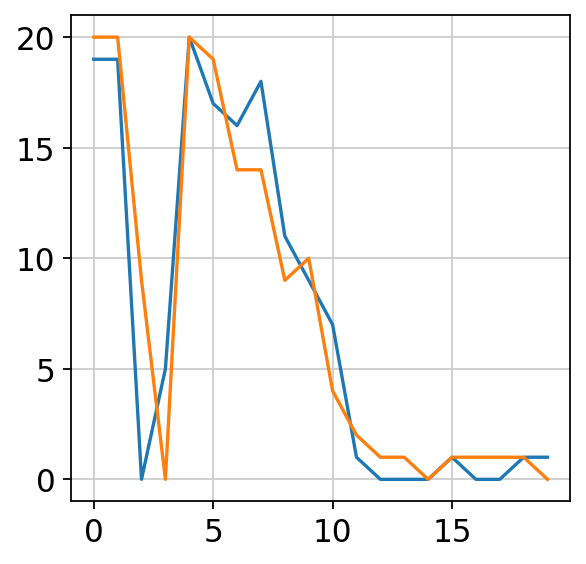

In [96]:
# orthonormalise eigenvectors before use!!!
adata.varm['PCs'],x = la.qr(adata.varm['PCs'], mode='economic')
adata.varm['PCs_approx'],x = la.qr(adata.varm['PCs_approx'], mode='economic')
#adata.varm['PCs'],x = la.qr(adata.varm['PCs'], mode='economic')


ttl, tll = compare_loadings(adata.varm['PCs'],adata.varm['PCs_approx'])
sns.lineplot(x =range(len(ttl)), y = ttl)
sns.lineplot(x =range(len(tll)), y = tll)

pd.DataFrame(ttl).to_csv('/home/anne/Documents/featurecloud/pca/horizontal-pca/results/single-cell/overlap_top_s30.tsv', sep='\t')
pd.DataFrame(tll).to_csv('/home/anne/Documents/featurecloud/pca/horizontal-pca/results/single-cell/overlap_bottom_s30.tsv', sep='\t')


In [97]:
angles = co.compute_angles(adata.varm['PCs_approx'], adata.varm['PCs'])[0:10]
angles = [np.round(a, 2) for a in angles]
pd.DataFrame(angles).to_csv('/home/anne/Documents/featurecloud/pca/horizontal-pca/results/single-cell/angles_cent_approx_s30.tsv', sep='\t')

The outliers are not equally distributed over the sites. We observe strong distortion.

### Outlier distribution with a different seed.
#### Seed =40 : The outliers are more equally distributed and the PCA plot looks more like the original

In [98]:
# simulate federated approximate PCA with lseed= 40
np.random.seed(40)
X = adata.X
c = np.random.choice(X.shape[0], X.shape[0], replace=False)
X = X[c]
data_list, r = sh.partition_data_horizontally(X, splits=5, equal=True, randomize=False)
dl= [d.shape[0] for d in data_list]
k = 10
xx, ee = b.simulate_federated_horizontal_pca(data_list, k)
proj = np.dot(adata.X, xx)
adata.obsm['PC'] = proj
adata.varm['PCs_approx'] = xx
#sc.pl.embedding(adata, color='CST3', basis = 'PC', components =['1,2'], save='CST3_12_k10_s40')
#sc.pl.embedding(adata, color='CST3', basis = 'PC', components =['2,3'], save='CST3_23_k10_s40')

(20, 1838)
(20, 1838)
(20, 1838)
(20, 1838)
(20, 1838)
Intermediate dimensions20
(100, 1838)


<AxesSubplot:ylabel='Count'>

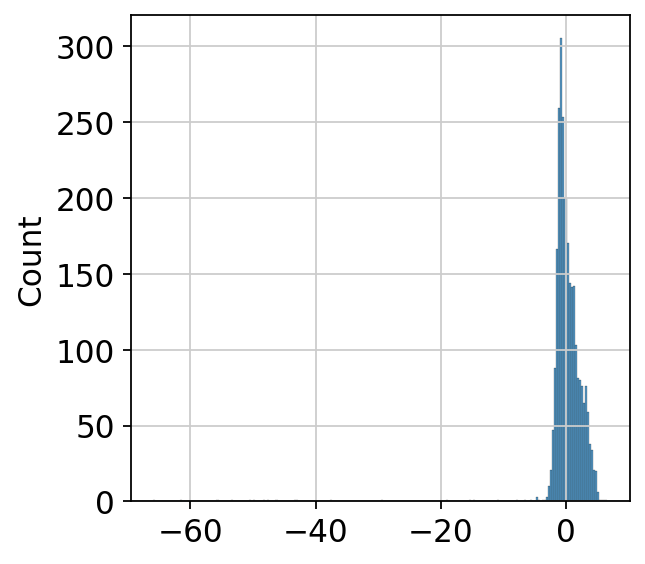

In [99]:
#
sns.histplot(proj[:,2])

In [100]:
ol = np.where(proj[:,2]<-6)[0]

In [101]:
#Determine the indices in each partition and and the outlier indices per partition
boundaries = []
current= 0
cho = []
for d in dl:
    cho.append(c[current:current+d])
    current = current+d
    boundaries.append(current)
section = [set(ol).intersection(cc) for cc in cho]

In [102]:
section
nol = [len(d) for d in section]

In [103]:
nol

[2, 7, 5, 2, 3]

Outliers per site: [2, 7, 5, 2, 3]

The outliers are distributed equally among the sites. Therefore small distortion is observed.

#### We also look at different k to see if we really need that many eigenvectors/projections/dimensions

(10, 1838)
(10, 1838)
(10, 1838)
(10, 1838)
(10, 1838)
Intermediate dimensions10
(50, 1838)


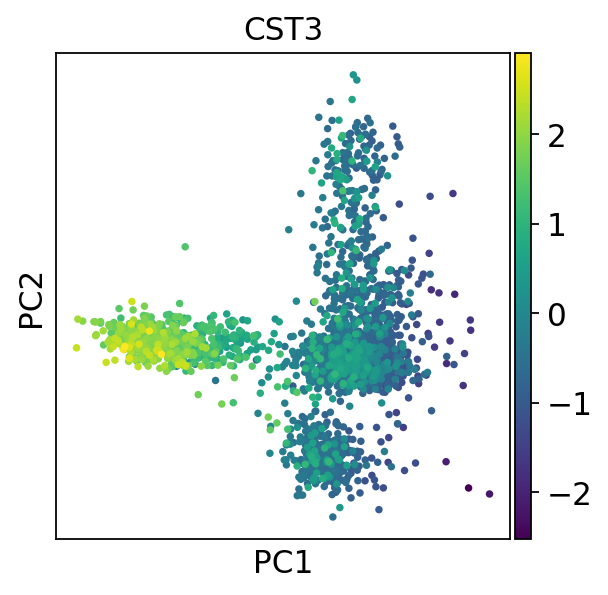

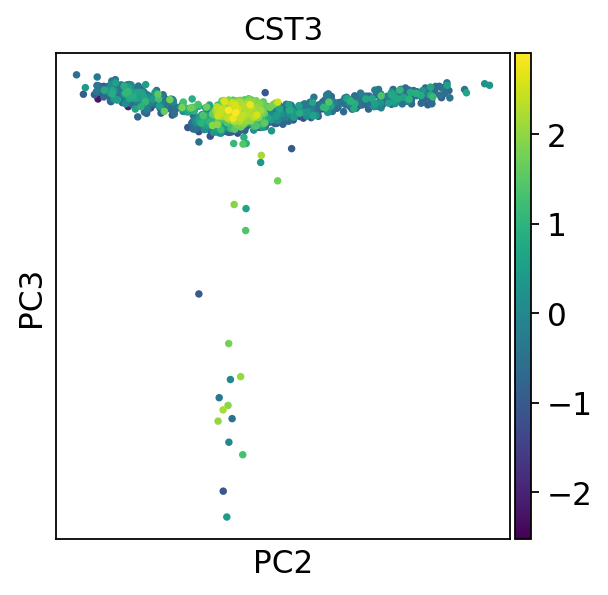

In [104]:
# simulate federated approximate PCA with lower k
np.random.seed(40)
X = adata.X
X = X[np.random.choice(X.shape[0], X.shape[0], replace=False)]
data_list, r = sh.partition_data_horizontally(X, splits=5, equal=True, randomize=False)
k = 5
xx, ee = b.simulate_federated_horizontal_pca(data_list, k)
proj = np.dot(adata.X, xx)
adata.obsm['PC'] = proj
adata.varm['PCs_approx'] = xx
sc.pl.embedding(adata, color='CST3', basis = 'PC', components =['1,2'], save='CST3_12_k5_s40')
sc.pl.embedding(adata, color='CST3', basis = 'PC', components =['2,3'], save='CST3_23_k5_s40')

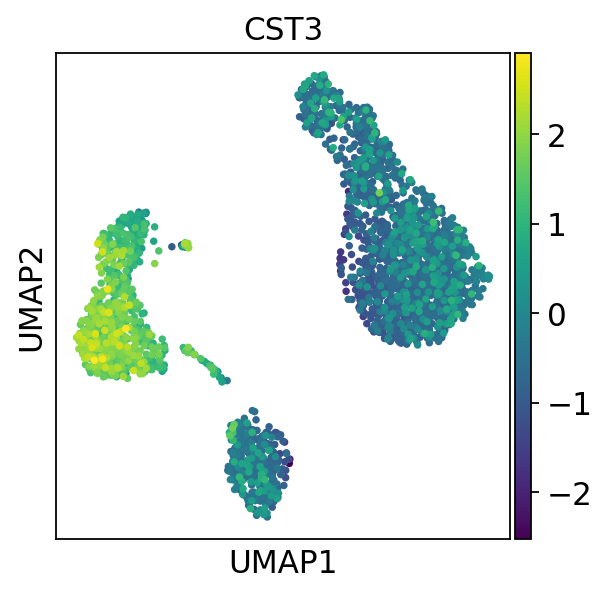

In [105]:
sc.pp.neighbors(adata, use_rep='PC', key_added='approx')
sc.tl.umap(adata, neighbors_key='approx')
sc.pl.umap(adata, color=['CST3'], neighbors_key='approx',  save='CST3_approx_k5_S40')

(400, 1838)
(400, 1838)
(400, 1838)
(400, 1838)
(400, 1838)
Intermediate dimensions400
(2000, 1838)


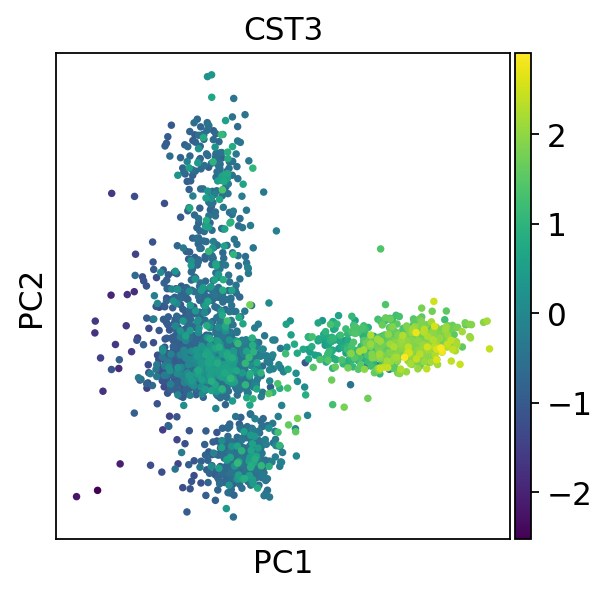

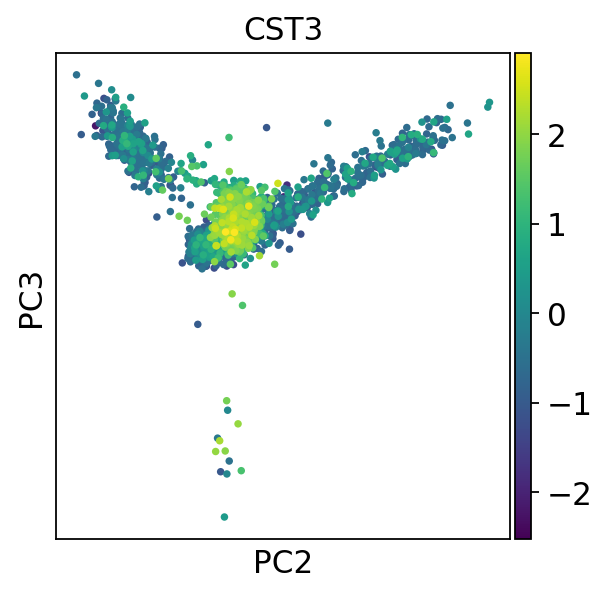

In [106]:
# simulate federated approximate PCA with higher k
X = adata.X
X = X[np.random.choice(X.shape[0], X.shape[0], replace=False)]
data_list, r = sh.partition_data_horizontally(adata.X, splits=5, equal=True, randomize=False)
k = 200
xx, ee = b.simulate_federated_horizontal_pca(data_list, k)
proj = np.dot(adata.X, xx)
adata.obsm['PC'] = proj[:, 0:30]
adata.varm['PCs_approx'] = xx
sc.pl.embedding(adata, color='CST3', basis = 'PC', components =['1,2'], save='CST3_12_k200_s40')
sc.pl.embedding(adata, color='CST3', basis = 'PC', components =['2,3'], save='CST3_23_k200_s40')

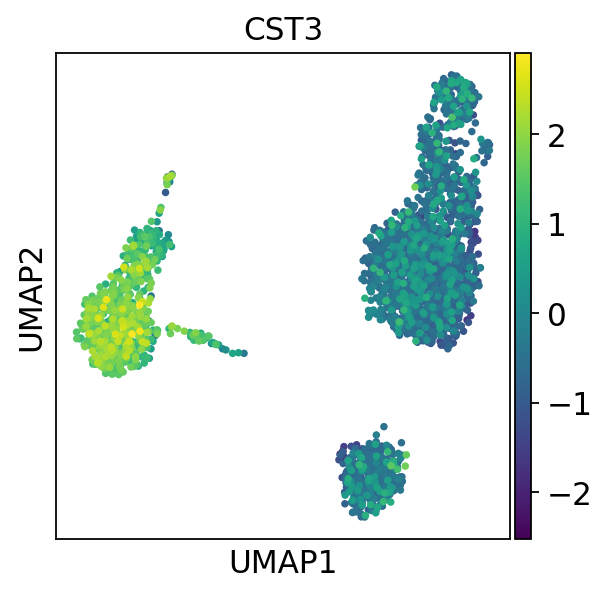

In [107]:
sc.pp.neighbors(adata, use_rep='PC', key_added='approx')
sc.tl.umap(adata, neighbors_key='approx')
sc.pl.umap(adata, color=['CST3'], neighbors_key='approx',  save='CST3_approx_k200')

### Clustering with extremely biased split according to clustering
To show that the problem are really the outliers, here we perform PCA on an extremely biased data split. We first cluster the data according to the centralised UMAP into three clusters. Then we simulate federated approximate PCA with one cluster per site and send. The results of the PC plots and the UMAPs look ok.

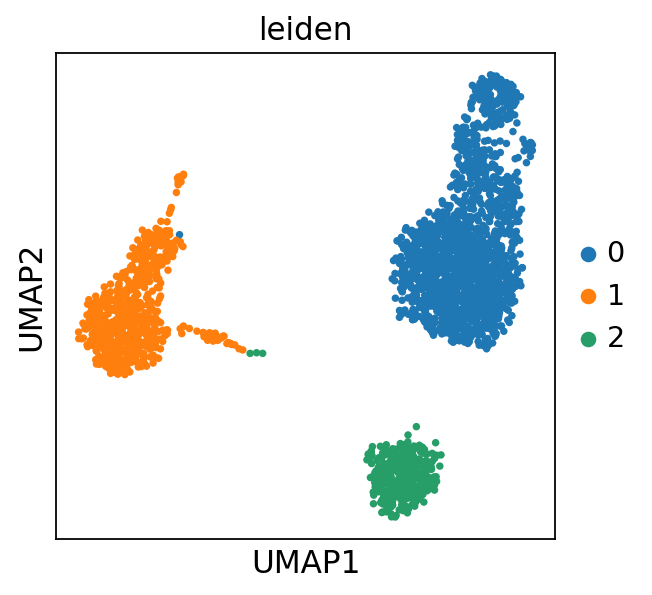

In [108]:
sc.tl.leiden(adata, neighbors_key='approx', resolution=0.1)
sc.pl.umap(adata, color=['leiden'], use_raw=False,neighbors_key='approx', save='clustered_3')


In [109]:
# simulate federated approximate PCA with higher k
X = adata.X
data_list = []
for i in np.unique(adata.obs.leiden):
    data_list.append(X[adata.obs.leiden==i])


(400, 1838)
(400, 1838)
(343, 1838)
Intermediate dimensions400
(1143, 1838)


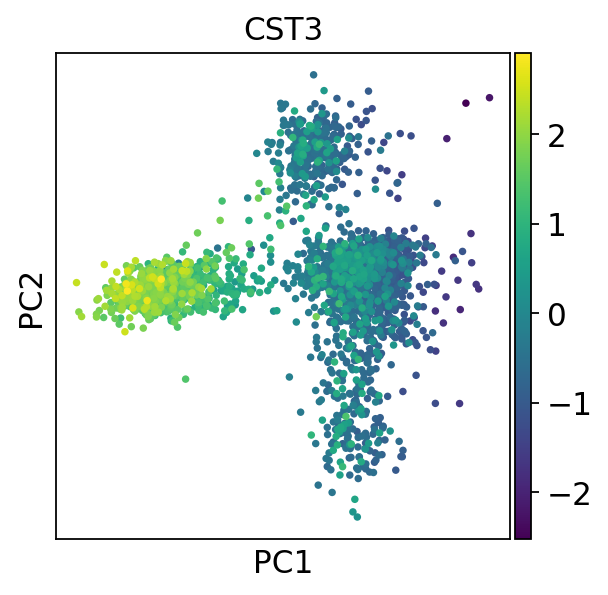

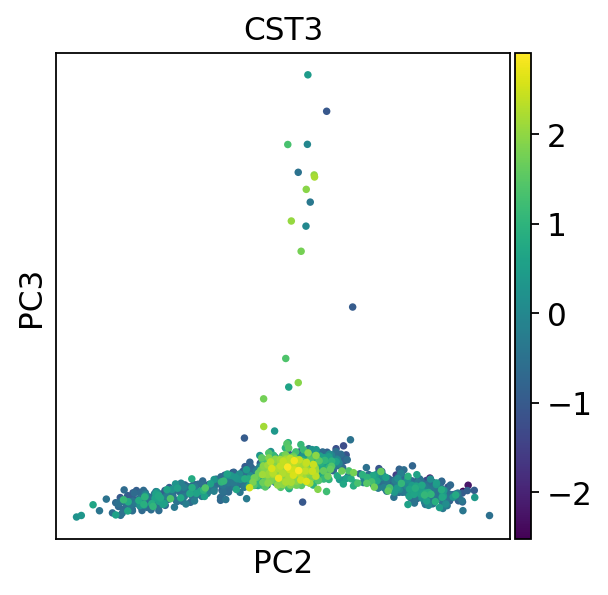

In [110]:
xx, ee = b.simulate_federated_horizontal_pca(data_list, k)
proj = np.dot(adata.X, xx)
adata.obsm['PC'] = proj[:, 0:30]
adata.varm['PCs_approx'] = xx
sc.pl.embedding(adata, color='CST3', basis = 'PC', components =['1,2'], save='CST3_12_clustered_s40')
sc.pl.embedding(adata, color='CST3', basis = 'PC', components =['2,3'], save='CST3_23_clustered_s40')

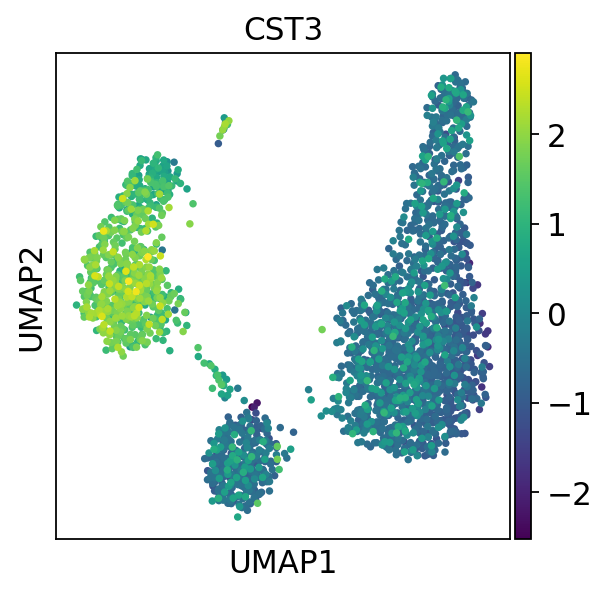

In [111]:
sc.pp.neighbors(adata, use_rep='PC', key_added='approx')
sc.tl.umap(adata, neighbors_key='approx')
sc.pl.umap(adata, color=['CST3'], neighbors_key='approx',  save='CST3_approx_clustered_s40')